In [1]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from function import spearman_corr_heatmap

import warnings
warnings.simplefilter(action='ignore')

In [2]:
df = pd.read_csv("../00_data/03_final/cbsa_level.csv")
gdf = gpd.read_file("../00_data/01_raw/tl_2024_us_cbsa", engine="pyogrio")
gdf['cbsacode'] = gdf['CBSAFP'].astype('float64')

In [3]:
gdf["ALAND_acres"] = gdf["ALAND"] / 4046.8564224
df = df.merge(gdf[['ALAND_acres','cbsacode']],how='left')
df['density'] = df["TotalPopulation"]/df["ALAND_acres"]

In [4]:
df

,cbsacode,TotalPopulation,BINGE,CSMOKING,DEPRESSION,DIABETES,LPA,OBESITY,adult_smoking,adult_obesity,...,noise80n,noise90n,CANCER,VISION,MOBILITY,SELFCARE,DISABILITY,Park_Area_Acres,ALAND_acres,density
0,10100.0,42037,8802.089,5942.090,7630.409,3886.342,9800.073,14822.801,0.341,0.681,...,6.824776,3.068829,3684.287,1747.907,4794.896,1239.398,11896.471,550.773301,1.816967e+06,0.023136
1,10140.0,77038,12865.346,11555.700,20954.336,9937.902,19105.424,28427.022,0.190,0.360,...,7.306492,1.801527,7780.838,4622.280,13712.764,3620.786,27348.490,104080.141400,1.216937e+06,0.063305
2,10180.0,179308,33724.319,27437.232,43682.746,22629.731,49045.578,64315.187,0.561,1.116,...,134.775549,21.393130,13006.378,11088.890,27337.236,7314.732,60962.299,3252.752494,1.755849e+06,0.102120
3,10220.0,38141,5263.458,7475.636,11327.877,5377.881,12433.966,16400.630,0.214,0.367,...,3.799527,0.091602,3013.139,2631.729,7513.777,1754.486,16972.745,87.794807,4.610259e+05,0.082731
4,10300.0,98567,16559.256,16066.421,23754.647,11335.205,26021.688,41496.707,0.204,0.395,...,7.036913,0.545557,9166.731,4829.783,13799.380,3548.412,30851.471,741.377599,4.797683e+05,0.205447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,49660.0,426279,70236.063,90823.818,107573.664,67051.467,128537.013,177133.518,0.503,0.767,...,130.858132,15.124541,40496.505,28059.435,79288.593,20411.406,153136.929,5621.076757,6.586099e+05,0.647240
871,49700.0,182813,33171.767,28898.647,41820.750,22149.607,48250.135,58527.698,0.295,0.604,...,85.952259,11.647516,12923.799,12755.179,28336.863,8423.591,63057.140,888.207710,7.902092e+05,0.231348
872,49740.0,207842,35748.824,27642.986,40529.190,32215.510,65054.546,84176.010,0.151,0.384,...,24.067545,3.407328,16627.360,18082.254,38035.086,11431.310,76693.698,434.539877,3.528844e+06,0.058898
873,49780.0,86113,15328.114,16533.696,22217.154,12141.933,24628.318,35392.443,0.261,0.394,...,27.677967,1.952414,7922.396,4650.102,13778.080,3358.407,29020.081,15833.810080,4.253093e+05,0.202471


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

rows = []

id_col = "cbsacode"
pop_col = "density"

# factors: all numeric except ID and population
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
factors = [c for c in numeric_cols if c not in [id_col, pop_col]]

for factor in factors:
    # keep only observations with positive Y and N for logs
    valid = (df[factor] > 0) & (df[pop_col] > 0)
    if valid.sum() < 3:
        continue  # not enough data points to fit

    y_log = np.log(df.loc[valid, factor])
    X = sm.add_constant(np.log(df.loc[valid, pop_col]))
    X.columns = ["const", f"log_{pop_col}"]

    model = sm.OLS(y_log, X).fit()

    # fitted log Y and SAMI (log residuals)
    yhat_log = model.predict(X)
    sami = y_log - yhat_log

    # slope & stats
    beta = model.params[f"log_{pop_col}"]
    pval = model.pvalues[f"log_{pop_col}"]
    ci_low, ci_up = model.conf_int().loc[f"log_{pop_col}"]
    logY0_hat = model.params["const"]

    # append one row per CBSA in the valid set
    for i, cbsa in df.loc[valid, id_col].items():
        rows.append({
            "cbsacode": cbsa,
            "factor": factor,
            "SAMI": float(sami.loc[i]),       # ξ_i = log-residual
            "beta": float(beta),
            "p_value": float(pval),
            "CI_lower": float(ci_low),
            "CI_upper": float(ci_up),
            "logY0_hat": float(logY0_hat),
            "n_used": int(valid.sum()),
            "r2": float(model.rsquared)
        })

results_df = pd.DataFrame(rows)

In [7]:
results_df.to_csv('../00_data/04_output/SAMIs_den.csv')

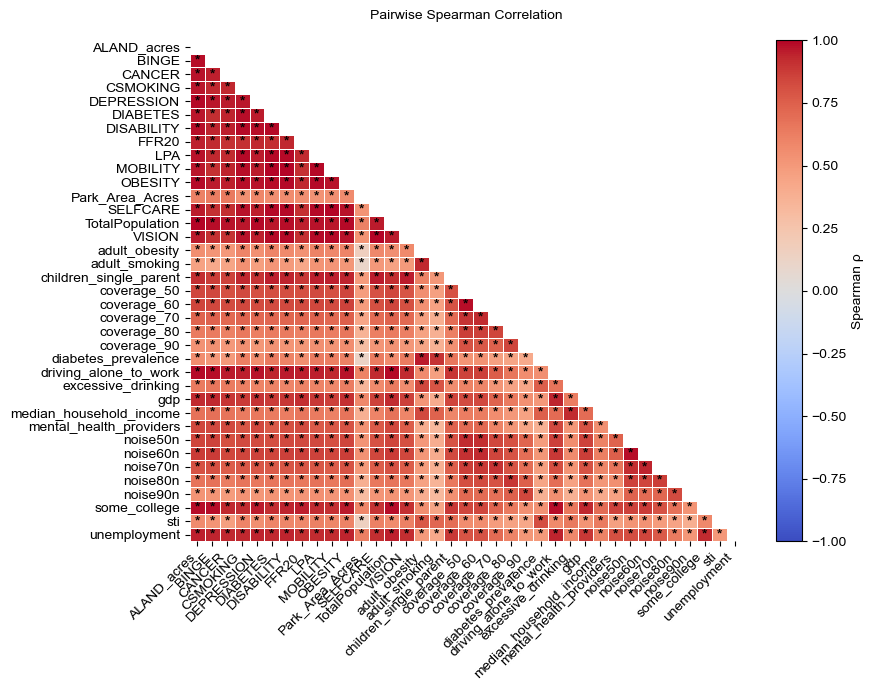

In [8]:
sami_wide = results_df.pivot(index="cbsacode", columns="factor", values="SAMI")

cols = [c for c in sami_wide.columns if c not in ['cbsacode']]
corr, pvals = spearman_corr_heatmap(sami_wide, columns=cols,figsize=(9, 7), savepath=None)